In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import date, timedelta
from scipy.stats import skew, kurtosis

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K

2023-11-30 13:56:43.944120: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 13:56:44.102694: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 13:56:44.102772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 13:56:44.122147: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 13:56:44.165892: I tensorflow/core/platform/cpu_feature_guar

In [2]:
### IMPORT SPEKTRAL CLASSES ###

from spektral_utilities import *
from spektral_gcn import GraphConv

In [22]:
file_path = "../data/WHO-COVID-19-global-data.csv"
date_column = "Date_reported"
target_column = "New_deaths"
id_column = "WHO_region"
df = pd.read_csv(file_path)[[date_column, target_column, id_column]]
df[date_column] = pd.to_datetime(df[date_column])
df = df.groupby([date_column, id_column])[target_column].sum().reset_index()
# df[id_column] = 'A'
unique_dates = df[date_column].unique()
um_countries_regions = len(df[id_column].unique())
df.head()

,Date_reported,WHO_region,New_deaths
0,2020-01-03,AFRO,0
1,2020-01-03,AMRO,0
2,2020-01-03,EMRO,0
3,2020-01-03,EURO,0
4,2020-01-03,Other,0


In [23]:
pivot_df = df.pivot_table(index=date_column, columns=id_column, values=target_column)

# Rename 'index' back to date_columneported
df.rename(columns={"index": date_column}, inplace=True)
# df[date_column] = pd.to_datetime(df[date_column])
# unique_dates = df[date_column].unique()
# df.set_index(date_column, inplace=True)
df.head()


,Date_reported,WHO_region,New_deaths
0,2020-01-03,AFRO,0
1,2020-01-03,AMRO,0
2,2020-01-03,EMRO,0
3,2020-01-03,EURO,0
4,2020-01-03,Other,0


In [24]:
unstaked_df = df.copy()
unstaked_df["id"] = unstaked_df["WHO_region"]
unstaked_df.set_index(["id", "Date_reported"], inplace=True)

# Dropping columns not needed for the analysis
unstaked_df.drop(["WHO_region"], axis=1, inplace=True)

# Converting data to float and unstacking
unstaked_df = unstaked_df.astype(float).unstack()
unstaked_df.columns = unstaked_df.columns.get_level_values(1)

# Displaying the shape and head of the updated DataFrame
print(unstaked_df.shape)
unstaked_df.iloc[:, :15].head()

(7, 1420)


Date_reported,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-11,2020-01-12,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17
id,,,,,,,,,,,,,,,
AFRO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AMRO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EMRO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EURO,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Other,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
### UTILITY FUNCTIONS FOR FEATURE ENGINEERING ###

sequence_length = 14



def get_timespan(df, today, days):    
    df = df[pd.date_range(today - timedelta(days=days), 
            periods=days, freq='D')] # day - n_days <= dates < day    
    return df

def create_features(df, today, seq_len):
    
    all_sequence = get_timespan(df, today, seq_len).values
    
    group_store = all_sequence.reshape((-1, um_countries_regions, seq_len))
    
    store_corr = np.stack([np.corrcoef(i) for i in group_store], axis=0)
    
    store_features = np.stack([
              group_store.mean(axis=2),
              group_store[:,:,int(sequence_length/2):].mean(axis=2),
              group_store.std(axis=2),
              group_store[:,:,int(sequence_length/2):].std(axis=2),
              skew(group_store, axis=2),
              kurtosis(group_store, axis=2),
              np.apply_along_axis(lambda x: np.polyfit(np.arange(0, sequence_length), x, 1)[0], 2, group_store)
            ], axis=1)
    
    group_store = np.transpose(group_store, (0,2,1))
    store_features = np.transpose(store_features, (0,2,1))
    
    return group_store, store_corr, store_features

def create_label(df, today):
    
    y = df[today].values
    
    return y.reshape((-1, um_countries_regions))

In [73]:
### DEFINE TRAIN, VALID, TEST DATES ###

train_date = unique_dates[0]
valid_date = unique_dates[-(len(unique_dates) // 2) + 1]
test_date = unique_dates[-len(unique_dates) // 4]

In [74]:
X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(train_date + timedelta(days=sequence_length), valid_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)

X_train_seq = np.concatenate(X_seq, axis=0).astype("float16")
X_train_cor = np.concatenate(X_cor, axis=0).astype("float16")
X_train_feat = np.concatenate(X_feat, axis=0).astype("float16")
y_train = np.concatenate(y, axis=0).astype("float16")

print(X_train_seq.shape, X_train_cor.shape, X_train_feat.shape, y_train.shape)

  0%|          | 0/698 [00:00<?, ?it/s]

/home/samuell/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/samuell/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 698/698 [00:02<00:00, 295.95it/s]

(698, 14, 7) (698, 7, 7) (698, 7, 7) (698, 7)


In [75]:
### CREATE VALID FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(valid_date + timedelta(days=sequence_length), test_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)

X_valid_seq = np.concatenate(X_seq, axis=0).astype("float16")
X_valid_cor = np.concatenate(X_cor, axis=0).astype("float16")
X_valid_feat = np.concatenate(X_feat, axis=0).astype("float16")
y_valid = np.concatenate(y, axis=0).astype("float16")

print(X_valid_seq.shape, X_valid_cor.shape, X_valid_feat.shape, y_valid.shape)

100%|██████████| 341/341 [00:01<00:00, 280.49it/s]

(341, 14, 7) (341, 7, 7) (341, 7, 7) (341, 7)


In [76]:
### CREATE TEST FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(
    pd.date_range(test_date + timedelta(days=sequence_length), unique_dates[-1])
):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)

X_test_seq = np.concatenate(X_seq, axis=0).astype("float16")
X_test_cor = np.concatenate(X_cor, axis=0).astype("float16")
X_test_feat = np.concatenate(X_feat, axis=0).astype("float16")
y_test = np.concatenate(y, axis=0).astype("float16")

print(X_test_seq.shape, X_test_cor.shape, X_test_feat.shape, y_test.shape)

100%|██████████| 341/341 [00:01<00:00, 296.43it/s]

(341, 14, 7) (341, 7, 7) (341, 7, 7) (341, 7)


In [77]:
### SCALE SEQUENCES ###

scaler_seq = StandardScaler()
scaler_feat = StandardScaler()

X_train_seq = scaler_seq.fit_transform(
    X_train_seq.reshape(-1, um_countries_regions)
).reshape(X_train_seq.shape)
X_valid_seq = scaler_seq.transform(
    X_valid_seq.reshape(-1, um_countries_regions)
).reshape(X_valid_seq.shape)
X_test_seq = scaler_seq.transform(X_test_seq.reshape(-1, um_countries_regions)).reshape(
    X_test_seq.shape
)

y_train = scaler_seq.transform(y_train)
y_valid = scaler_seq.transform(y_valid)
y_test = scaler_seq.transform(y_test)

X_train_feat = scaler_feat.fit_transform(
    X_train_feat.reshape(-1, um_countries_regions)
).reshape(X_train_feat.shape)
X_valid_feat = scaler_feat.transform(
    X_valid_feat.reshape(-1, um_countries_regions)
).reshape(X_valid_feat.shape)
X_test_feat = scaler_feat.transform(
    X_test_feat.reshape(-1, um_countries_regions)
).reshape(X_test_feat.shape)

In [78]:
X_train_lap = localpooling_filter(1 - np.abs(X_train_cor))
X_valid_lap = localpooling_filter(1 - np.abs(X_valid_cor))
X_test_lap = localpooling_filter(1 - np.abs(X_test_cor))

In [113]:
def set_seed(seed):
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model():
    set_seed(33)

    opt = Adam(lr=0.001)

    inp_seq = Input((sequence_length, um_countries_regions))
    inp_lap = Input((um_countries_regions, um_countries_regions))
    inp_feat = Input((um_countries_regions, X_train_feat.shape[-1]))

    x = GraphConv(256, activation="relu")([inp_feat, inp_lap])
    x = GraphConv(128, activation="relu")([x, inp_lap])
    x = Flatten()(x)

    xx = LSTM(256, activation="relu", return_sequences=True)(inp_seq)
    xx = LSTM(128, activation="relu")(xx)

    x = Concatenate()([x, xx])
    # x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.1)(x)
    out = Dense(1)(x)

    model = Model([inp_seq, inp_lap, inp_feat], out)
    model.compile(
        optimizer=opt, loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

    return model

In [114]:
model = get_model()
model.summary()

Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_99 (InputLayer)       [(None, 7, 7)]               0         []                            
                                                                                                  
 input_98 (InputLayer)       [(None, 7, 7)]               0         []                            
                                                                                                  
 graph_conv_64 (GraphConv)   (None, 7, 256)               2048      ['input_99[0][0]',            
                                                                     'input_98[0][0]']            
                                                                                                  
 input_97 (InputLayer)       [(None, 14, 7)]              0         []                     

In [115]:
### TRAIN A MODEL FOR EACH STORES USING ALL THE DATA AVAILALBE FROM OTHER STORES ###

pred_valid_all = np.zeros(y_valid.shape)
pred_test_all = np.zeros(y_test.shape)

for store in range(um_countries_regions):
    print("-------", "store", store, "-------")

    es = EarlyStopping(
        patience=5,
        verbose=1,
        min_delta=0.001,
        monitor="val_loss",
        mode="auto",
        restore_best_weights=True,
    )

    model = get_model()
    model.fit(
        [X_train_seq, X_train_lap, X_train_feat],
        y_train[:, store],
        epochs=1000,
        batch_size=30,
        validation_data=([X_valid_seq, X_valid_lap, X_valid_feat], y_test[:, store]),
        callbacks=[es],
        verbose=2,
    )

    pred_valid_all[:, store] = model.predict(
        [X_valid_seq, X_valid_lap, X_valid_feat]
    ).ravel()
    pred_test_all[:, store] = model.predict(
        [X_test_seq, X_test_lap, X_test_feat]
    ).ravel()


pred_valid_all = scaler_seq.inverse_transform(pred_valid_all)
reverse_valid = scaler_seq.inverse_transform(y_valid)
pred_test_all = scaler_seq.inverse_transform(pred_test_all)
reverse_test = scaler_seq.inverse_transform(y_test)

------- store 0 -------
Epoch 1/1000
24/24 - 4s - loss: 0.9943 - root_mean_squared_error: 0.9972 - val_loss: 1.0154 - val_root_mean_squared_error: 1.0077 - 4s/epoch - 154ms/step
Epoch 2/1000
24/24 - 1s - loss: 0.9945 - root_mean_squared_error: 0.9972 - val_loss: 1.0068 - val_root_mean_squared_error: 1.0034 - 708ms/epoch - 29ms/step
Epoch 3/1000
24/24 - 1s - loss: 0.9949 - root_mean_squared_error: 0.9974 - val_loss: 1.0242 - val_root_mean_squared_error: 1.0120 - 670ms/epoch - 28ms/step
Epoch 4/1000
24/24 - 1s - loss: 0.9943 - root_mean_squared_error: 0.9972 - val_loss: 1.0165 - val_root_mean_squared_error: 1.0082 - 670ms/epoch - 28ms/step
Epoch 5/1000
24/24 - 1s - loss: 0.9945 - root_mean_squared_error: 0.9972 - val_loss: 1.0083 - val_root_mean_squared_error: 1.0041 - 664ms/epoch - 28ms/step
Epoch 6/1000
24/24 - 1s - loss: 0.9945 - root_mean_squared_error: 0.9972 - val_loss: 1.0219 - val_root_mean_squared_error: 1.0109 - 679ms/epoch - 28ms/step
Epoch 7/1000
Restoring model weights from 

------- store 1 -------
Epoch 1/1000
24/24 - 4s - loss: 0.9752 - root_mean_squared_error: 0.9875 - val_loss: 3.0833 - val_root_mean_squared_error: 1.7559 - 4s/epoch - 156ms/step
Epoch 2/1000
24/24 - 1s - loss: 0.9751 - root_mean_squared_error: 0.9875 - val_loss: 3.0506 - val_root_mean_squared_error: 1.7466 - 671ms/epoch - 28ms/step
Epoch 3/1000
24/24 - 1s - loss: 0.9748 - root_mean_squared_error: 0.9873 - val_loss: 3.0667 - val_root_mean_squared_error: 1.7512 - 680ms/epoch - 28ms/step
Epoch 4/1000
24/24 - 1s - loss: 0.9749 - root_mean_squared_error: 0.9874 - val_loss: 3.0536 - val_root_mean_squared_error: 1.7475 - 688ms/epoch - 29ms/step
Epoch 5/1000
24/24 - 1s - loss: 0.9749 - root_mean_squared_error: 0.9874 - val_loss: 3.0424 - val_root_mean_squared_error: 1.7442 - 671ms/epoch - 28ms/step
Epoch 6/1000
24/24 - 1s - loss: 0.9748 - root_mean_squared_error: 0.9873 - val_loss: 3.0459 - val_root_mean_squared_error: 1.7452 - 676ms/epoch - 28ms/step
Epoch 7/1000
24/24 - 1s - loss: 0.9751 - r

Epoch 1/1000
24/24 - 4s - loss: 0.9779 - root_mean_squared_error: 0.9889 - val_loss: 2.7056 - val_root_mean_squared_error: 1.6449 - 4s/epoch - 157ms/step
Epoch 2/1000
24/24 - 1s - loss: 0.9777 - root_mean_squared_error: 0.9888 - val_loss: 2.7149 - val_root_mean_squared_error: 1.6477 - 671ms/epoch - 28ms/step
Epoch 3/1000
24/24 - 1s - loss: 0.9776 - root_mean_squared_error: 0.9887 - val_loss: 2.7225 - val_root_mean_squared_error: 1.6500 - 665ms/epoch - 28ms/step
Epoch 4/1000
24/24 - 1s - loss: 0.9775 - root_mean_squared_error: 0.9887 - val_loss: 2.7206 - val_root_mean_squared_error: 1.6494 - 675ms/epoch - 28ms/step
Epoch 5/1000
24/24 - 1s - loss: 0.9777 - root_mean_squared_error: 0.9888 - val_loss: 2.7095 - val_root_mean_squared_error: 1.6461 - 663ms/epoch - 28ms/step
Epoch 6/1000
Restoring model weights from the end of the best epoch: 1.
24/24 - 1s - loss: 0.9777 - root_mean_squared_error: 0.9888 - val_loss: 2.7284 - val_root_mean_squared_error: 1.6518 - 674ms/epoch - 28ms/step
Epoch 6

------- store 3 -------
Epoch 1/1000
24/24 - 4s - loss: 1.0103 - root_mean_squared_error: 1.0051 - val_loss: 0.4619 - val_root_mean_squared_error: 0.6796 - 4s/epoch - 159ms/step
Epoch 2/1000
24/24 - 1s - loss: 1.0095 - root_mean_squared_error: 1.0047 - val_loss: 0.4812 - val_root_mean_squared_error: 0.6937 - 683ms/epoch - 28ms/step
Epoch 3/1000
24/24 - 1s - loss: 1.0092 - root_mean_squared_error: 1.0046 - val_loss: 0.4781 - val_root_mean_squared_error: 0.6914 - 669ms/epoch - 28ms/step
Epoch 4/1000
24/24 - 1s - loss: 1.0091 - root_mean_squared_error: 1.0045 - val_loss: 0.4843 - val_root_mean_squared_error: 0.6959 - 655ms/epoch - 27ms/step
Epoch 5/1000
24/24 - 1s - loss: 1.0091 - root_mean_squared_error: 1.0045 - val_loss: 0.4840 - val_root_mean_squared_error: 0.6957 - 652ms/epoch - 27ms/step
Epoch 6/1000
Restoring model weights from the end of the best epoch: 1.
24/24 - 1s - loss: 1.0091 - root_mean_squared_error: 1.0045 - val_loss: 0.4872 - val_root_mean_squared_error: 0.6980 - 671ms/e

------- store 4 -------
Epoch 1/1000
24/24 - 4s - loss: 1.0007 - root_mean_squared_error: 1.0004 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1156 - 4s/epoch - 157ms/step
Epoch 2/1000
24/24 - 1s - loss: 1.0007 - root_mean_squared_error: 1.0003 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1144 - 670ms/epoch - 28ms/step
Epoch 3/1000
24/24 - 1s - loss: 1.0008 - root_mean_squared_error: 1.0004 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1221 - 678ms/epoch - 28ms/step
Epoch 4/1000
24/24 - 1s - loss: 1.0007 - root_mean_squared_error: 1.0003 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1199 - 679ms/epoch - 28ms/step
Epoch 5/1000
24/24 - 1s - loss: 1.0006 - root_mean_squared_error: 1.0003 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1213 - 679ms/epoch - 28ms/step
Epoch 6/1000
Restoring model weights from the end of the best epoch: 1.
24/24 - 1s - loss: 1.0006 - root_mean_squared_error: 1.0003 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1184 - 679ms/e

------- store 5 -------
Epoch 1/1000
24/24 - 5s - loss: 0.9966 - root_mean_squared_error: 0.9983 - val_loss: 0.7808 - val_root_mean_squared_error: 0.8836 - 5s/epoch - 195ms/step
Epoch 2/1000
24/24 - 1s - loss: 0.9965 - root_mean_squared_error: 0.9983 - val_loss: 0.7789 - val_root_mean_squared_error: 0.8826 - 675ms/epoch - 28ms/step
Epoch 3/1000
24/24 - 1s - loss: 0.9965 - root_mean_squared_error: 0.9983 - val_loss: 0.7802 - val_root_mean_squared_error: 0.8833 - 669ms/epoch - 28ms/step
Epoch 4/1000
24/24 - 1s - loss: 0.9966 - root_mean_squared_error: 0.9983 - val_loss: 0.7790 - val_root_mean_squared_error: 0.8826 - 663ms/epoch - 28ms/step
Epoch 5/1000
24/24 - 1s - loss: 0.9965 - root_mean_squared_error: 0.9982 - val_loss: 0.7826 - val_root_mean_squared_error: 0.8847 - 674ms/epoch - 28ms/step
Epoch 6/1000
24/24 - 1s - loss: 0.9968 - root_mean_squared_error: 0.9984 - val_loss: 0.7934 - val_root_mean_squared_error: 0.8907 - 667ms/epoch - 28ms/step
Epoch 7/1000
Restoring model weights from 

------- store 6 -------
Epoch 1/1000
24/24 - 4s - loss: 1.0043 - root_mean_squared_error: 1.0022 - val_loss: 156.2550 - val_root_mean_squared_error: 12.5002 - 4s/epoch - 155ms/step
Epoch 2/1000
24/24 - 1s - loss: 1.0042 - root_mean_squared_error: 1.0021 - val_loss: 156.2502 - val_root_mean_squared_error: 12.5000 - 683ms/epoch - 28ms/step
Epoch 3/1000
24/24 - 1s - loss: 1.0042 - root_mean_squared_error: 1.0021 - val_loss: 156.2461 - val_root_mean_squared_error: 12.4998 - 676ms/epoch - 28ms/step
Epoch 4/1000
24/24 - 1s - loss: 1.0040 - root_mean_squared_error: 1.0020 - val_loss: 156.2462 - val_root_mean_squared_error: 12.4998 - 687ms/epoch - 29ms/step
Epoch 5/1000
24/24 - 1s - loss: 1.0043 - root_mean_squared_error: 1.0021 - val_loss: 156.2467 - val_root_mean_squared_error: 12.4999 - 676ms/epoch - 28ms/step
Epoch 6/1000
24/24 - 1s - loss: 1.0044 - root_mean_squared_error: 1.0022 - val_loss: 156.2368 - val_root_mean_squared_error: 12.4995 - 663ms/epoch - 28ms/step
Epoch 7/1000
24/24 - 1s 

In [116]:
### RMSE ON TEST DATA ###



error = np.sqrt(mean_squared_error(reverse_test, pred_test_all))
pred_test_all

array([[2.e+02, 3.e+03, 4.e+02, ..., 2.e-02, 1.e+03, 2.e+02],
       [2.e+02, 3.e+03, 4.e+02, ..., 2.e-02, 1.e+03, 2.e+02],
       [2.e+02, 3.e+03, 4.e+02, ..., 2.e-02, 1.e+03, 2.e+02],
       ...,
       [2.e+02, 3.e+03, 4.e+02, ..., 2.e-02, 1.e+03, 2.e+02],
       [2.e+02, 3.e+03, 4.e+02, ..., 2.e-02, 1.e+03, 2.e+02],
       [2.e+02, 3.e+03, 4.e+02, ..., 2.e-02, 1.e+03, 2.e+02]])

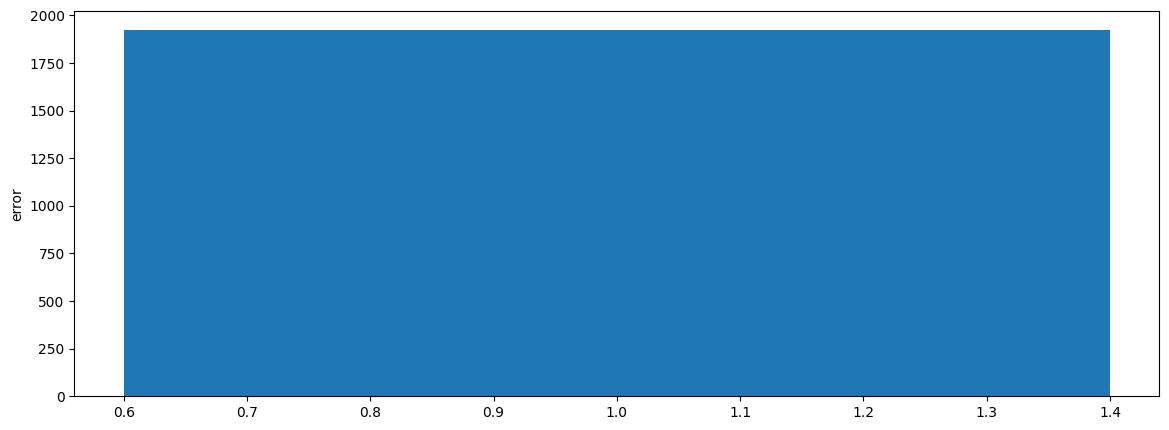

In [117]:
### PLOT RMSE ###

plt.figure(figsize=(14, 5))
plt.bar(1 ,error)
# plt.xticks(range(7), [str(s) for s in range(7)])
plt.ylabel("error")
np.set_printoptions(False)

In [118]:
def plot_predictions(y_true, y_pred, store, item):
    y_true = y_true.reshape(1, -1, 7)
    y_pred = y_pred.reshape(1, -1, 7)
    t = y_true[item, :, store]
    for i in range(7):

    plt.plot(y_true[item, :, store], label="true")
    plt.plot(y_pred[item, :, store], label="prediction")
    plt.title(f"store: {store} item: {item}")
    plt.legend()
    plt.ylabel("sales")
    plt.xlabel("date")

In [120]:
plt.figure(figsize=(11, 5))
plot_predictions(reverse_test, pred_test_all, 6, 1)

IndexError: index 1 is out of bounds for axis 0 with size 1

<Figure size 1100x500 with 0 Axes>